In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [211]:
import os
import psycopg2 as pg

conn = pg.connect(
    host=os.getenv('DATA_HOST'), 
    port=os.getenv('DATA_PORT'), 
    database=os.getenv('DATA_DB_NAME'), 
    user=os.getenv('DATA_DB_USER'), 
    password=os.getenv('DATA_DB_PASS'),
)

# df = pd.read_csv('files/data.csv')

In [212]:
df = pd.read_sql('SELECT * from realestate', conn)

In [213]:
df.shape

(12671, 19)

In [214]:
df.head(3)

,fingerprint,title,description,posted_date,price,currency,partitioning,surface,building_year,floor,number_of_rooms,terrace,parking,cellar,source_website,source_offer,neighborhood,link,scraped_date
0,74e17d23a02495e3b88bf44092cb1db038746db2,"inchiriere studio, centru",capital imobiliare va propune spre inchiriere un studio situat in ...,2019-09-27 15:54:54.472305,600,EUR,semidecomandat,30.0,1970,1.0,1.0,False,False,False,lajumate,companie,central,https://lajumate.ro/inchiriere-studio-centru-10668359.html,2019-09-27 16:00:54.451592
1,9a31af8d7611751bf4ce6bab9f2578e50af4134e,Apartament 3 camere mobilat utilat Mihai Viteazu,Descriere anunt.css-k7cvuo{line-height:25px;display:block;position...,2019-08-20 12:21:20.515434,350,EUR,decomandat,70.0,2007,5.0,3.0,False,True,False,storia,,viteazu,https://www.storia.ro/oferta/apartament-3-camere-mobilat-utilat-mi...,NaT
2,08ae8b49015d9782a775020623dba1866ac9f084,Apartament 2 camere zona calea dumbravi,Descriere anunt.css-k7cvuo{line-height:25px;display:block;position...,2019-08-20 12:21:29.130445,300,EUR,decomandat,56.0,None,1.0,2.0,False,False,False,storia,,not found,https://www.storia.ro/oferta/apartament-2-camere-zona-calea-dumbra...,NaT


In [215]:
df['title'] = df['title'].str.lower()

# Some description were badly scraped and contain css formatting
# This corrects that
mask = df.description.str.contains('css', case=False)
df.loc[mask, 'description'] = df.loc[mask, 'description'].apply(lambda p: (p.split('}')[9]).split('.css-1prr4ql')[0])

df['description'] = df['description'].str.lower()

In [216]:
# Uneeded for analysis
df = df.drop('fingerprint', 1)
df.drop('source_website', 1, inplace=True)
df.drop('link', 1, inplace=True)
df.drop('scraped_date', 1, inplace=True)

In [217]:
# Updating column name
df.rename(columns={'number_of_rooms': 'rooms'}, inplace=True)

In [218]:
# Dropping rows that don't have a posting date
df = df.dropna(subset=['posted_date'])

In [219]:
df['posted_date_month'] = df['posted_date'].dt.strftime('%m')
df['posted_date_month'] = pd.to_numeric(df['posted_date_month'], errors='coerce')
df = df.loc[df.posted_date_month > 3]
df = df.loc[df.posted_date_month < 10]

In [220]:
df['posted_date'] = df['posted_date'].map(lambda d: str(d).split(' ')[0])

In [221]:
df['price'] = pd.to_numeric(df['price'], errors='coerce')

In [222]:
df.groupby('currency').size()

currency
EUR    12324
RON      209
dtype: int64

In [223]:
sort_df = df.sort_values(by='posted_date')
print(sort_df.head(1)['posted_date'])
print(sort_df.tail(1)['posted_date'])

634    2019-04-01
Name: posted_date, dtype: object
5741    2019-09-30
Name: posted_date, dtype: object


In [224]:
# Average currency value from the earliest to the latest result
avg_eur_to_ron = 4.732

# Apply the conversion only to rows with RON currency
mask = df['currency'] == 'RON'
df.loc[mask, 'price'] = df.loc[mask, 'price'].apply(
    lambda p: p / avg_eur_to_ron
)

# Currency is all the same, so it's an irrelevant observation
df.drop('currency', 1, inplace=True)

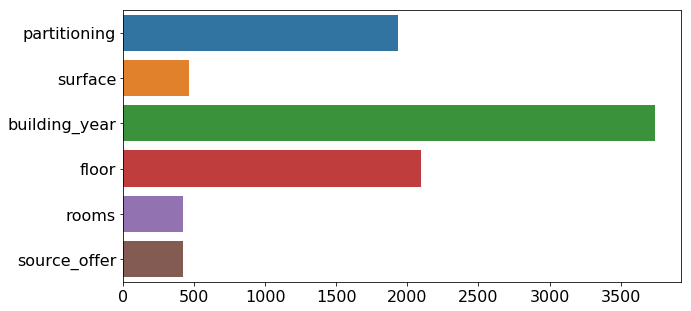

In [225]:
# Number of null values per column
df_nulls = df.isnull().sum()
df_nulls = df_nulls[df_nulls > 0]
nulls_graph = sb.barplot(x=df_nulls.values, y=df_nulls.index)

In [226]:
df = df[df.neighborhood != 'not found']

In [227]:
df.head(5)

,title,description,posted_date,price,partitioning,surface,building_year,floor,rooms,terrace,parking,cellar,source_offer,neighborhood,posted_date_month
0,"inchiriere studio, centru",capital imobiliare va propune spre inchiriere un studio situat in ...,2019-09-27,600.0,semidecomandat,30.0,1970,1.0,1.0,False,False,False,companie,central,9
1,apartament 3 camere mobilat utilat mihai viteazu,oferim spre inchiriere aprtament cu 3 camere situat in zona buleva...,2019-08-20,350.0,decomandat,70.0,2007,5.0,3.0,False,True,False,,viteazu,8
2,apartament 2 camere zona calea dumbravi,apartament 2 camere decomandat de inchiriat in sibiu zona calea du...,2019-08-20,300.0,decomandat,56.0,None,1.0,2.0,False,False,False,,not found,8
3,"apartament 2 camere, 70 mp, semidecomandat, zona ultracentrala",blitz ofera spre inchiriere apartament cu 2 camere semidecomandate...,2019-08-28,550.0,None,70.0,None,1.0,2.0,False,False,False,,ultracentral,8
4,inchiriez ap 2 camera 48m mp in cartierul manastur,inchiriez ap cu 1 camera cu living si bucatarie baie camara la cas...,2019-09-23,350.0,nedecomandat,48.0,None,NaN,1.0,False,False,False,proprietar,manastur,9


In [228]:
# Nullify missing values
df.source_offer = df.source_offer.replace({
    '': None
})

In [229]:
# Wrapping in dataframe for better display
pd.DataFrame(
    df.groupby('source_offer').size(), columns=['count']
)

,count
source_offer,
Agentie,26
Proprietar,30
agentie,5001
agentie imobiliara,1306
companie,355
constructor,4
persoana fizica,599
persoană fizică,14
proprietar,3025


In [230]:
df['source_offer'].isna().sum()

2173

In [231]:
df['source_offer'] = df['source_offer'].str.lower()
df['source_offer'] = df['source_offer'].fillna('unknown')

df.source_offer = df.source_offer.replace({
    'agentie': 'real estate agency',
    'companie': 'real estate agency',
    'constructor': 'building company',
    'persoana fizica': 'owner',
    'persoană fizică': 'owner',
    'proprietar': 'owner',
    'agentie imobiliara': 'real estate agency'
})

In [232]:
df.groupby('neighborhood').size()

neighborhood
? string:18 ?             1
andrei muresanu         279
aurel vlaicu              3
baciu                    67
becas                     1
borhanci                 54
bulgaria                 15
buna ziua               664
calea turzii            186
campului                 27
central                  89
centru                  970
dambul rotund            46
dorobantilor            159
est                       1
europa                  143
expo transilvania        19
faget                     2
floresti                154
gara                    827
gheorgheni              916
grigorescu              369
gruia                    52
hasdeu                   33
horea                    79
interservisan            36
intre lacuri            180
iris                    153
iulius                  640
manastur               1146
marasti                1127
muzeului                 17
not found              1665
p-ta mihai viteazul      20
piata unirii             47
plopilo

In [233]:
mapping = {
    'calea turzii': 'andrei muresanu',
    'sigma': 'zorilor',
    'cipariu':'centru',
    'motilor':'centru', 
    'muzeului':'centru', 
    'piata unirii':'centru', 
    'viteazu': 'centru', 
    'ultracentral': 'centru',
    'the office': 'marasti',
    'usamv': 'manastur',
    'polus': 'vivo',
    'interservisan': 'gheorgheni', 
    'titulescu': 'gheorgheni', 
    'iulius': 'gheorgheni',
    'expo transilvania':'intre lacuri',
    'semicentral': 'centru',
    'aurel vlaicu': 'marasti',
    'dorobantilor': 'marasti',
    'central': 'centru',
    'vest': 'floresti',
    'est': 'someseni',
    'campului': 'manastur',
    'gara': 'centru',
    'horea': 'centru',
    'hasdeu': 'centru',
    'p-ta mihai viteazul': 'centru',
    'vivo': 'floresti',
}
df.neighborhood = df.neighborhood.replace(mapping)
df = df.loc[df.neighborhood != '? string:18 ?']

In [234]:
df['price_sqm'] = df['price'] / df['surface']

In [235]:
df.floor = df.floor.astype(str)
df.floor = df.floor.map(lambda d: str(d).split('.')[0])
df.floor = df.floor.replace({'99': 'attic', '0': 'ground floor', '-1': 'basement'})

In [236]:
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams.update({'font.size': 16})

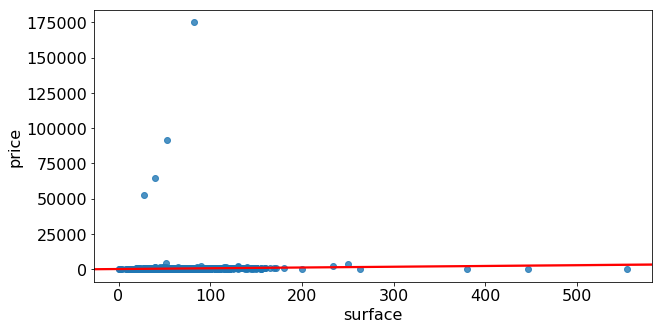

In [237]:
# Exploring the linear relationship between price and surface
kwargs = {'line_kws': {'color':'red'}}
# kwargs2 = {'line_kws': {'color':'yellow'}}
# fig, ax = plt.subplots()
# data = [[65, 420]]
# df2 = pd.DataFrame(data, columns=["surface", "price"])
lr = sns.regplot(x="surface", y="price", data=df, **kwargs)
# lr = sns.regplot(x="surface", y="price", data=df2, ax=ax, fit_reg=False, **kwargs2)

In [238]:
# Outliers can be brought on by sellers 
# wrongly marking apartments for sale as for rent
# Or just general mislabeling and  extreme values
df = df.loc[df.price > 100]
df = df.loc[df.price < 2000]
df = df.loc[df.surface < 200]
df = df.loc[df.surface > 15]

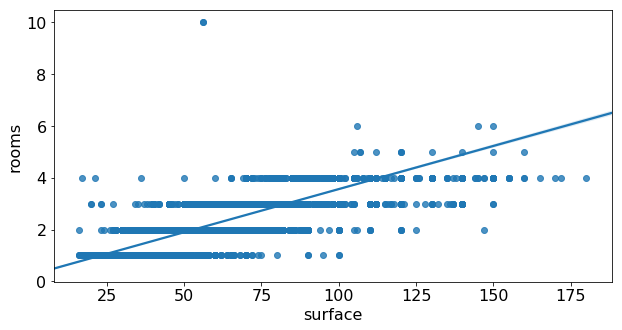

In [239]:
# Exploring the linear relationship between surface and rooms
linear_graph = sb.regplot(x="surface", y="rooms", data=df)

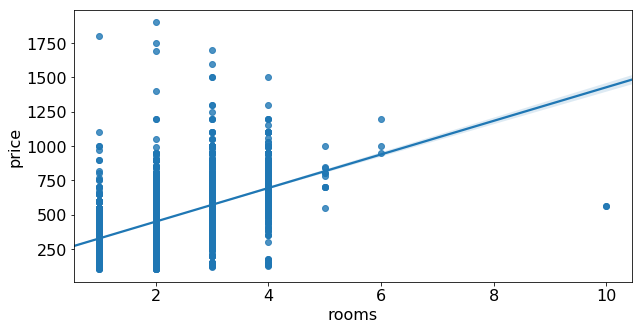

In [240]:
# Exploring the linear relationship between price and rooms
linear_graph = sb.regplot(x="rooms", y="price", data=df)

In [241]:
# Run until here to get data soft cleaned 
# df.to_csv('files/cleaned_re_data_full.csv', index=False)

In [242]:
# More aggresive cleaning
df = df.loc[df.rooms < 6]
df = df.loc[df.price_sqm < 25]

In [243]:
# Deleting office spaces, dorm, single rooms offerings
# since I'm only interested in full residential rooms
df = df.loc[df.title.str.contains('camera', case=False) == False]
df = df.loc[df.title.str.contains('camin', case=False) == False]
df = df.loc[df.title.str.contains(' ron', case=False) == False]
df = df.loc[df.title.str.contains('caut', case=False) == False]
df = df.loc[df.title.str.contains('birou', case=False) == False]

In [244]:
# Remove less than 10, not very helpful for statistics
df = df.groupby('neighborhood').filter(lambda x: len(x)>9)

In [245]:
df = df.drop('building_year', 1)

In [246]:
df.to_csv('files/cleaned_re_data_full.csv', index=False)

In [247]:
df.head(5)

,title,description,posted_date,price,partitioning,surface,floor,rooms,terrace,parking,cellar,source_offer,neighborhood,posted_date_month,price_sqm
0,"inchiriere studio, centru",capital imobiliare va propune spre inchiriere un studio situat in ...,2019-09-27,600.0,semidecomandat,30.0,1,1.0,False,False,False,real estate agency,centru,9,20.000000
1,apartament 3 camere mobilat utilat mihai viteazu,oferim spre inchiriere aprtament cu 3 camere situat in zona buleva...,2019-08-20,350.0,decomandat,70.0,5,3.0,False,True,False,unknown,centru,8,5.000000
2,apartament 2 camere zona calea dumbravi,apartament 2 camere decomandat de inchiriat in sibiu zona calea du...,2019-08-20,300.0,decomandat,56.0,1,2.0,False,False,False,unknown,not found,8,5.357143
3,"apartament 2 camere, 70 mp, semidecomandat, zona ultracentrala",blitz ofera spre inchiriere apartament cu 2 camere semidecomandate...,2019-08-28,550.0,None,70.0,1,2.0,False,False,False,unknown,centru,8,7.857143
5,chirie 2 camere gheorgheni,"inchiriez de la 1 octombrie apartament 2 camere, parter, strada he...",2019-09-23,400.0,semidecomandat,48.0,nan,2.0,False,False,False,owner,gheorgheni,9,8.333333


In [248]:
for month in range(4, 10):
    df = df.loc[df.posted_date_month == 9]
    df.to_csv(f'files/cleaned_re_data_{month}.csv', index=False)